<img src="../images/GA-logo.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore Housing Data and Kaggle Challenge

**Primary Learning Objectives:**

1. Creating and iteratively refining a regression model
2. Using Kaggle to practice the modeling process
3. Providing business insights through reporting and presentation.

We will clean the data and build a regression model based on Singapore Housing Dataset to predict the price of a house at sale.

This jupyter notebook focuses on conducting Exploratory Data Analysis (EDA) and Feature Engineering

----

### Contents:
- [External Research](#External-Research)
- [Data Import](#Data-Import)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))
- [Feature Engineering](#Feature-Engineering)
- [Data and Preprocessor Export](#Data-and-Preprocessor-Export)

In [49]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

from data_cleaning import generate_segments

from copy import deepcopy

import dill

%matplotlib inline

-----

## External Research

External research suggests that there are a few factors that can significantly influence a HDB flat's resale price (source: [propertyguru](https://www.propertyguru.com.sg/property-guides/hdb-valuation-sales-12882)). These are:

1. **Location**: (`town`, `planning_area`) more central locations tend to fetch higher prices
2. **Condition**: (`hdb_age`, `lease_commence_date`) renovated flats can fetch higher prices, newer flats in good condition can fetch higher prices
3. **Size and HDB type**: (`flat_type`, `flat_model`, `full_flat_type`) larger HDB and some flat types tend to fetch higher prices (e.g., masionette)
4. **Floor level**: (`storey range`, `mid_storey`, `lower`, `upper`, `mid`) higher floors tend to fetch higher prices because of better view

We will explore these variables first.

----

## Data Import

In [50]:
# read in clean dataset
housing_df = pd.read_csv('../datasets/train_cleaned.csv')

C:\Users\fishe\AppData\Local\Temp\ipykernel_17588\3481060378.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  housing_df = pd.read_csv('../datasets/train_cleaned.csv')


----

## Exploratory Data Analysis (EDA)

### Location-based variables

We first look at the correlation with outcome variable.

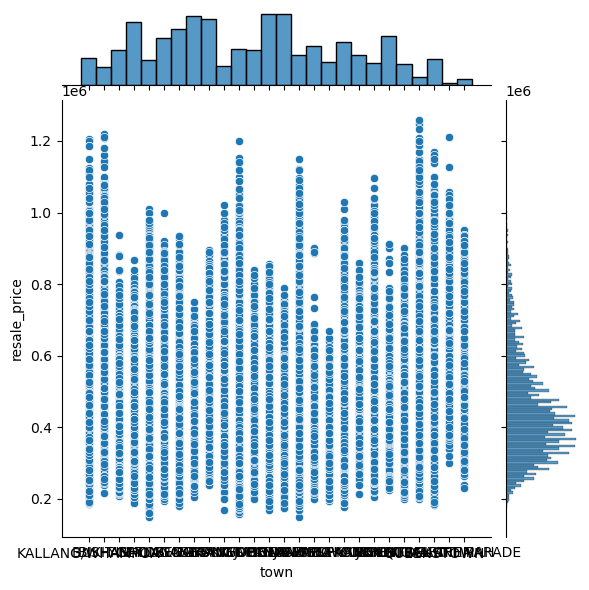

In [51]:
# check jointplot for town variable
sns.jointplot(housing_df, x='town', y='resale_price')

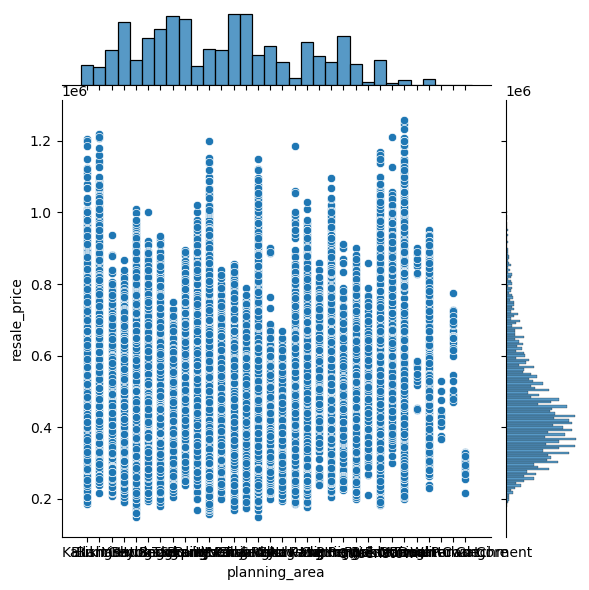

In [52]:
# check jointplot for planning_area variable
sns.jointplot(housing_df, x='planning_area', y='resale_price')

In [53]:
housing_df['planning_area'].value_counts(normalize=True)

Jurong West                0.076019
Woodlands                  0.075242
Sengkang                   0.073483
Tampines                   0.069745
Yishun                     0.066665
Bedok                      0.060159
Punggol                    0.051735
Hougang                    0.050168
Ang Mo Kio                 0.045860
Choa Chu Kang              0.042009
Bukit Merah                0.038862
Bukit Batok                0.037840
Bukit Panjang              0.037747
Toa Payoh                  0.031978
Pasir Ris                  0.031367
Queenstown                 0.027238
Geylang                    0.026461
Sembawang                  0.024716
Clementi                   0.024118
Jurong East                0.023036
Kallang                    0.020998
Serangoon                  0.020719
Bishan                     0.019059
Novena                     0.007243
Marine Parade              0.006260
Outram                     0.005039
Rochor                     0.003107
Bukit Timah                0

Observations:

- As seen in the Multicollinearity section, only 1 of the variables should be used
- `planning_area` variable shows more distinct distributions compared to `town` where many variables seemt o have the similar ranges of prices. As such, more inclined to use `planning_area`
- We also observe that some of the planning areas have similar `resale_price` distributions but others have significantly different distributions
- This suggests that each planning area may have a different correlation with `resale_price` and necessitate different fitted models
- As such, we will try out a model that has such segmentation

### Condition-based variables

We look at the correlation with outcome variable.

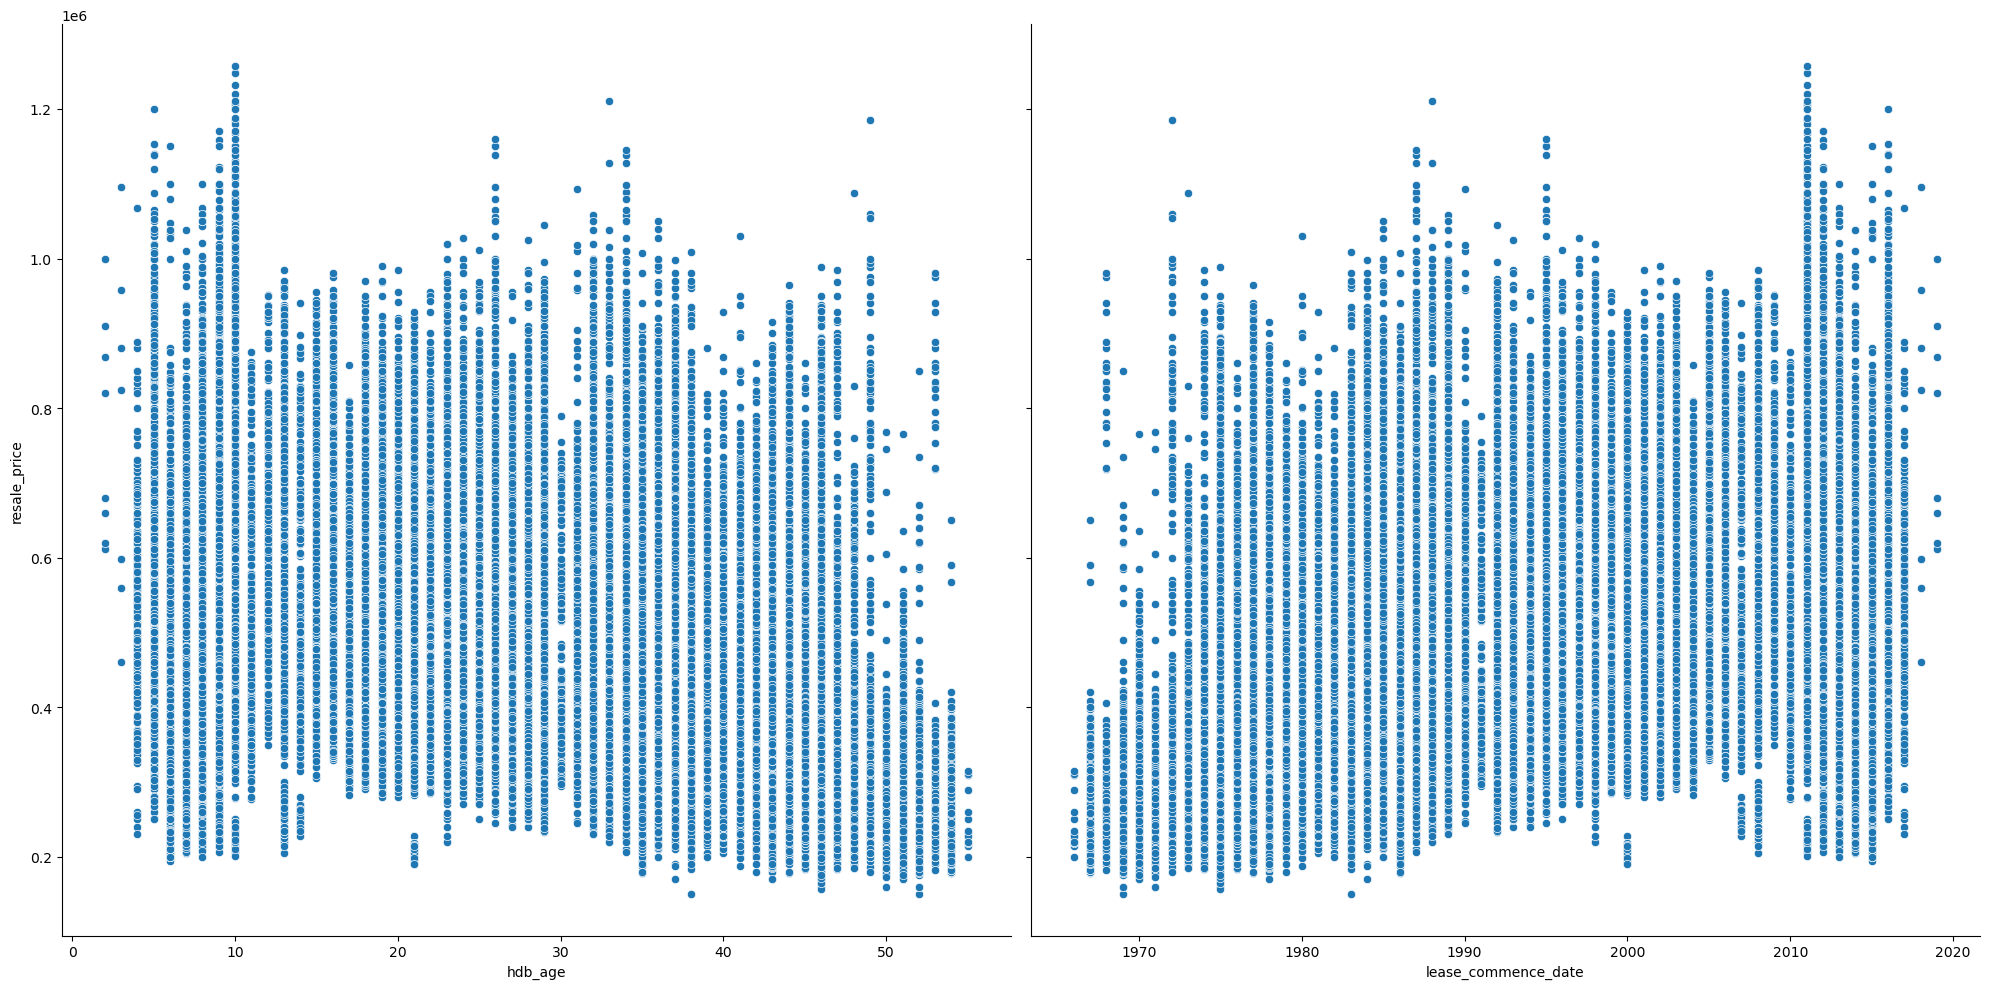

In [54]:
# check out pairplot of both variables
sns.pairplot(housing_df, y_vars='resale_price', x_vars=['hdb_age','lease_commence_date'],
            height=10)
plt.tight_layout()

Observations:

- As seen in the Multicollinearity section, only 1 of the variables should be used
- Unsurprisingly mirror image of one another, hence using one will suffice, will use `hdb_age`
- Range of resale prices seem to drop as HDBs gets older which is expected, albeit prices are very similar in the first decade
- Looks like outliers on the high end especially on the oldest HDBs. Slightly odd, perhaps these are heritage HDBs which are very limited in supply. Such characteristics should be picked up by flat model/type, given that such HDBs tend to have unique flat types

### Size and HDB-type variables

We look at the correlation with outcome variable.

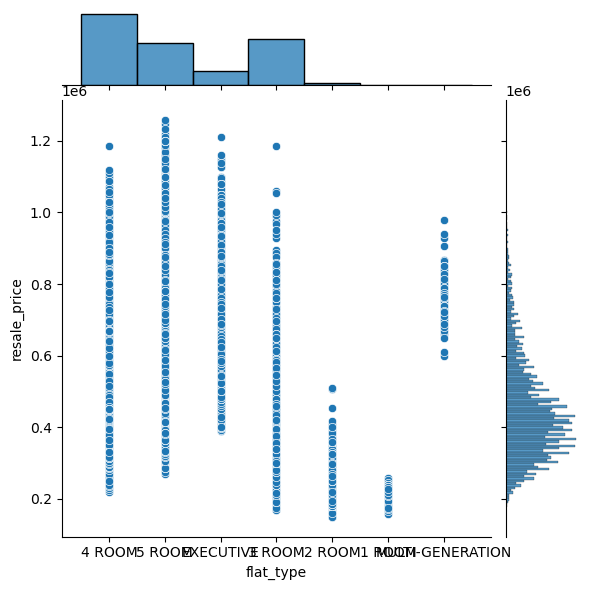

In [55]:
# check jointplot for flat_type variable
sns.jointplot(housing_df, x='flat_type', y='resale_price')

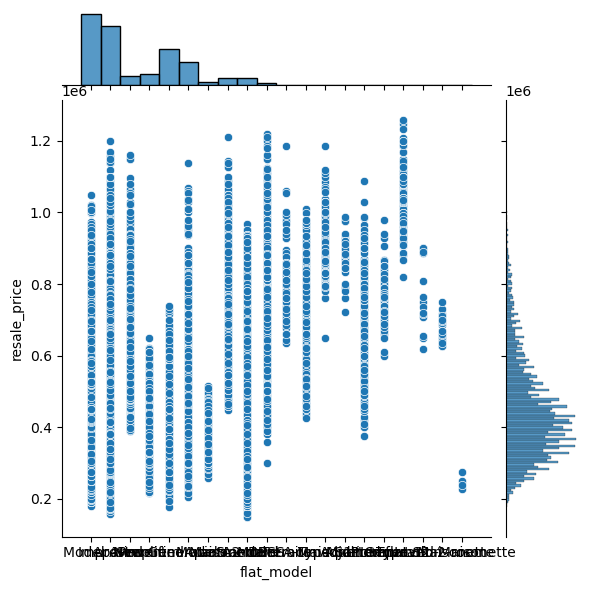

In [56]:
# check jointplot for flat_model variable
sns.jointplot(housing_df, x='flat_model', y='resale_price')

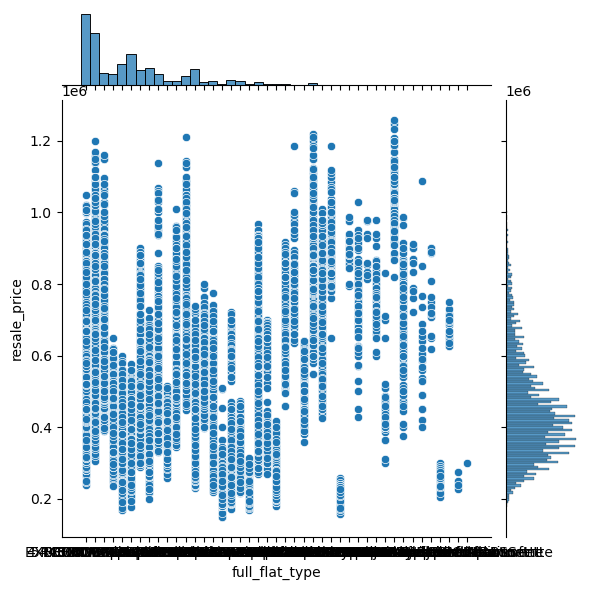

In [57]:
# check jointplot for full_flat_type variable
sns.jointplot(housing_df, x='full_flat_type', y='resale_price')

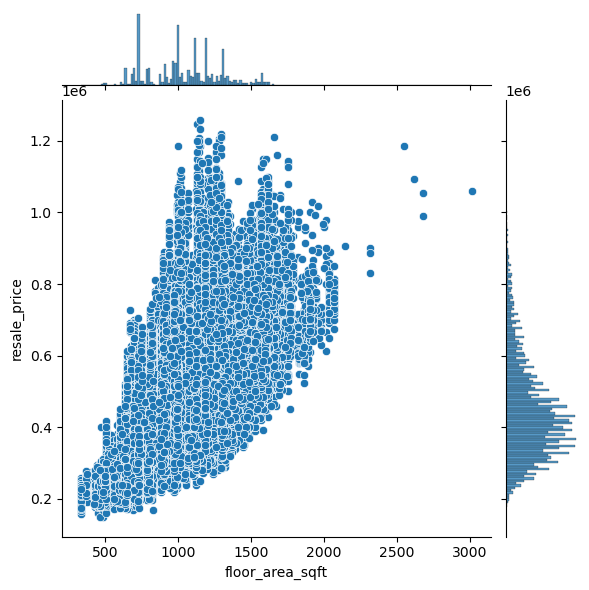

In [58]:
# check jointplot for full_flat_type variable
sns.jointplot(housing_df, x='floor_area_sqft', y='resale_price')

In [59]:
len(housing_df['flat_type'].unique())

7

In [60]:
len(housing_df['flat_model'].unique())

20

In [61]:
len(housing_df['full_flat_type'].unique())

43

Observations:

- As seen in the Multicollinearity section, only 1 or 2 of the categorical variables should be used
- `full_flat_type` will be most effective in segmenting and identifying variations due to both flat model and flat type, but there are 43 categories, meaning 43 dummies
- Alternative is to use `flat_type` and `flat_model` separately which generates only 27 dummies. This will assume no differences in interactive effects which is not reasonable, since the effect of a 3-room flat being a masionette will likely be different from a 4-room flat being a masionette
- As such, we try using `full_flat_type` first
- `floor_area_sqft` correlates very well with outcome variable, so will include

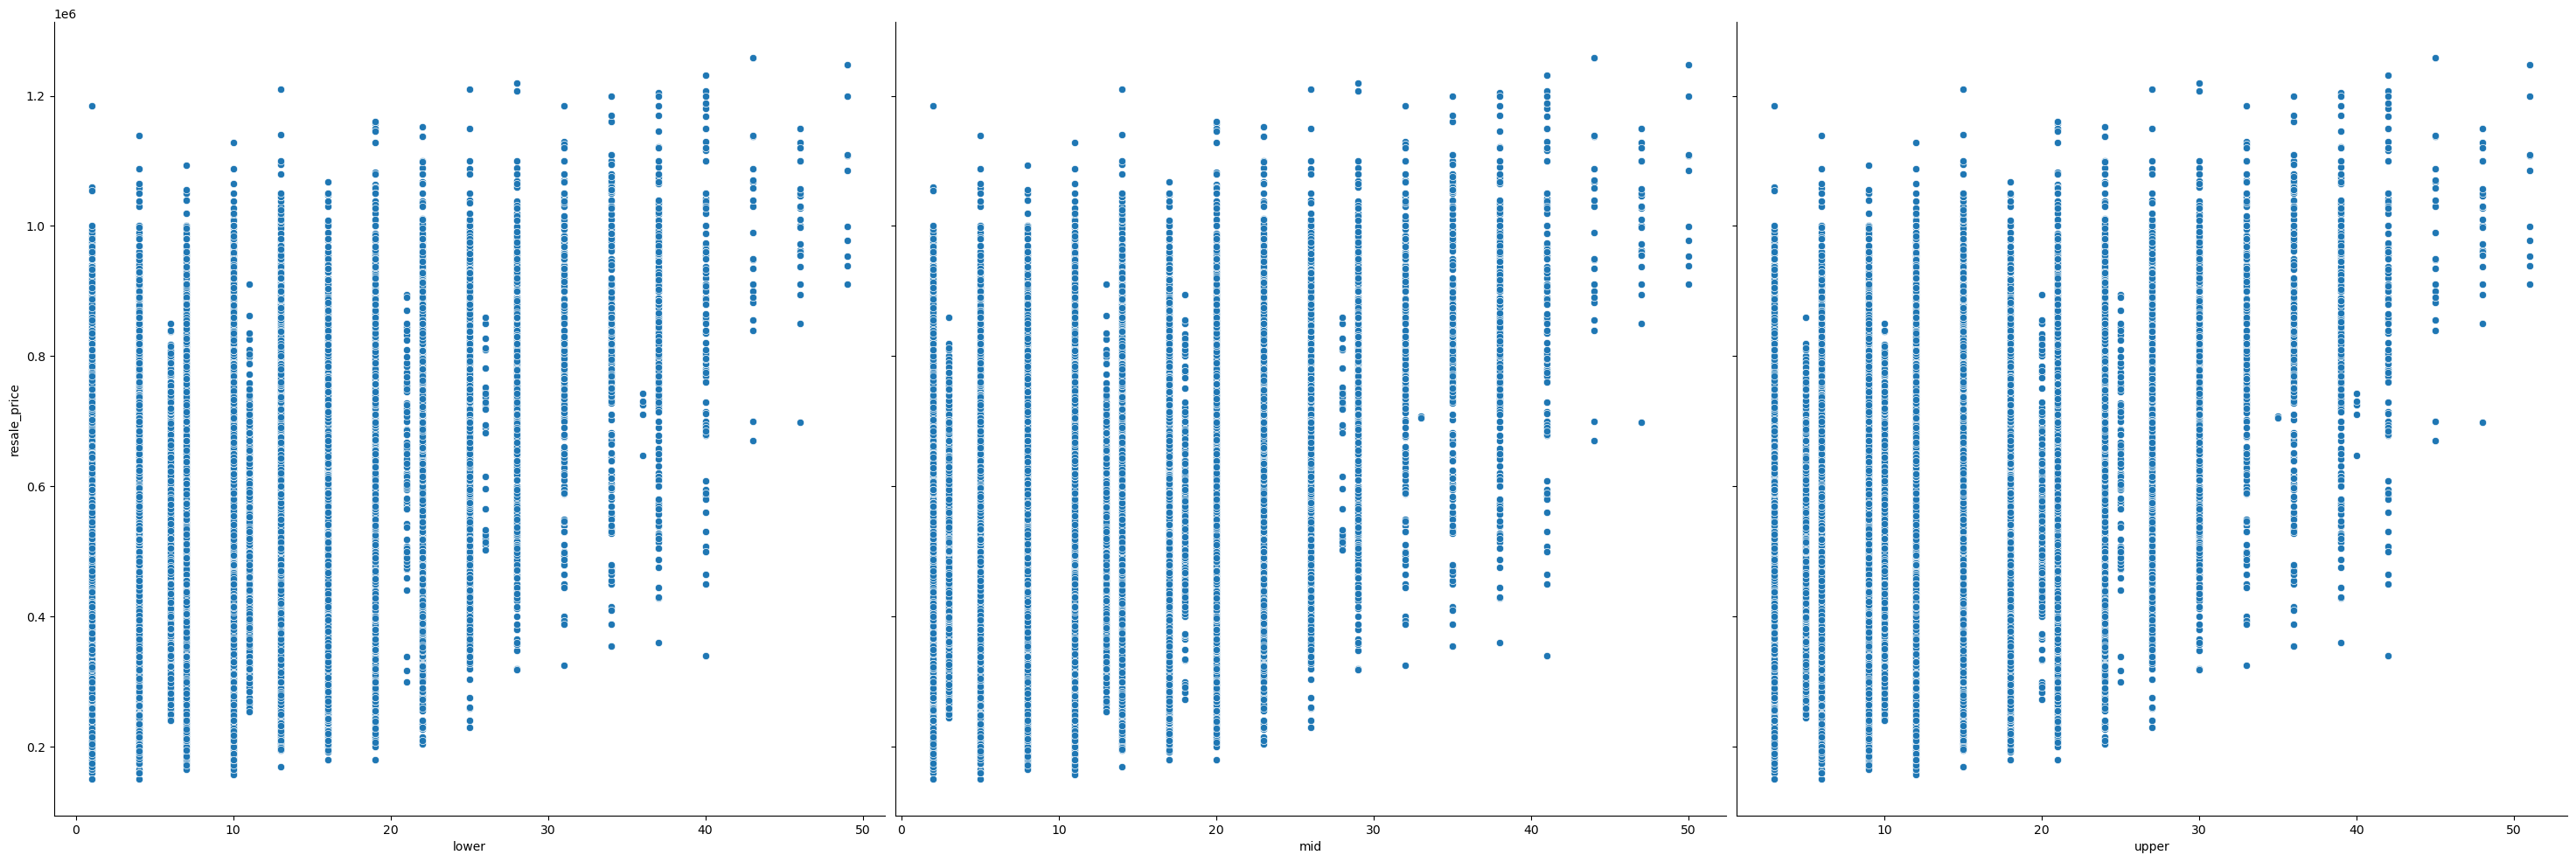

In [62]:
sns.pairplot(housing_df, x_vars=['lower', 'mid', 'upper'], y_vars='resale_price', height=10)

### Seasonality

Different years and months of transaction may have an effect on resale price, so we will check it out

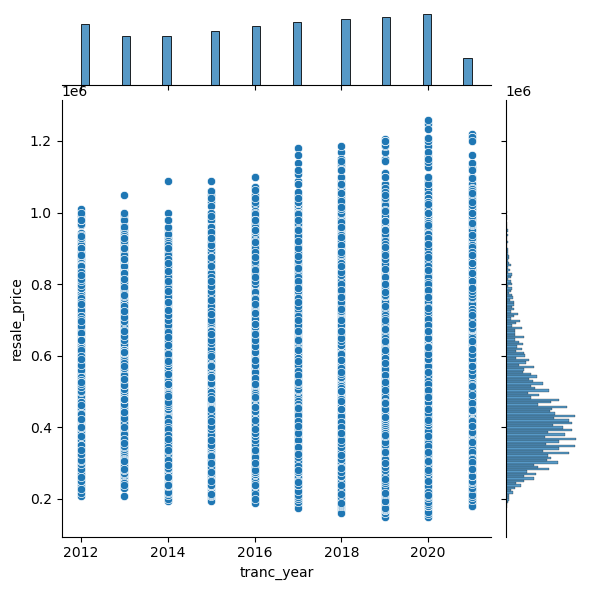

In [63]:
sns.jointplot(housing_df, x='tranc_year', y='resale_price')

Observations:

- Looks like slight upward trend with some years being better than others (e.g., 2020 is very good)
- We will include `tranc_year` as a time control

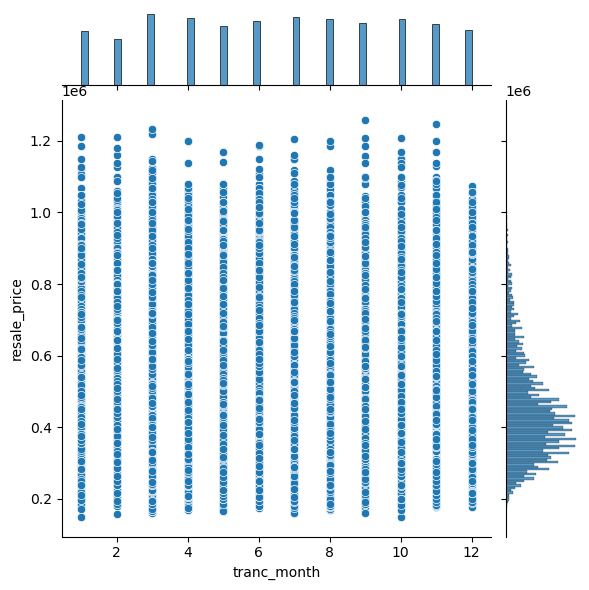

In [64]:
sns.jointplot(housing_df, x='tranc_month', y='resale_price')

Observations:

- Some months are better (e.g., Sep and Nov)
- We will include `tranc_month` as a time control

### Presence of amenities

While our research did not bring up the presence of amenities as key factors that influence resale price, it is logical that presence of amenities can influence resale price to some extent (perhaps 2-3% impact)

As such, we will explore the amenities variables and decide which to include

#### `mall` amenity

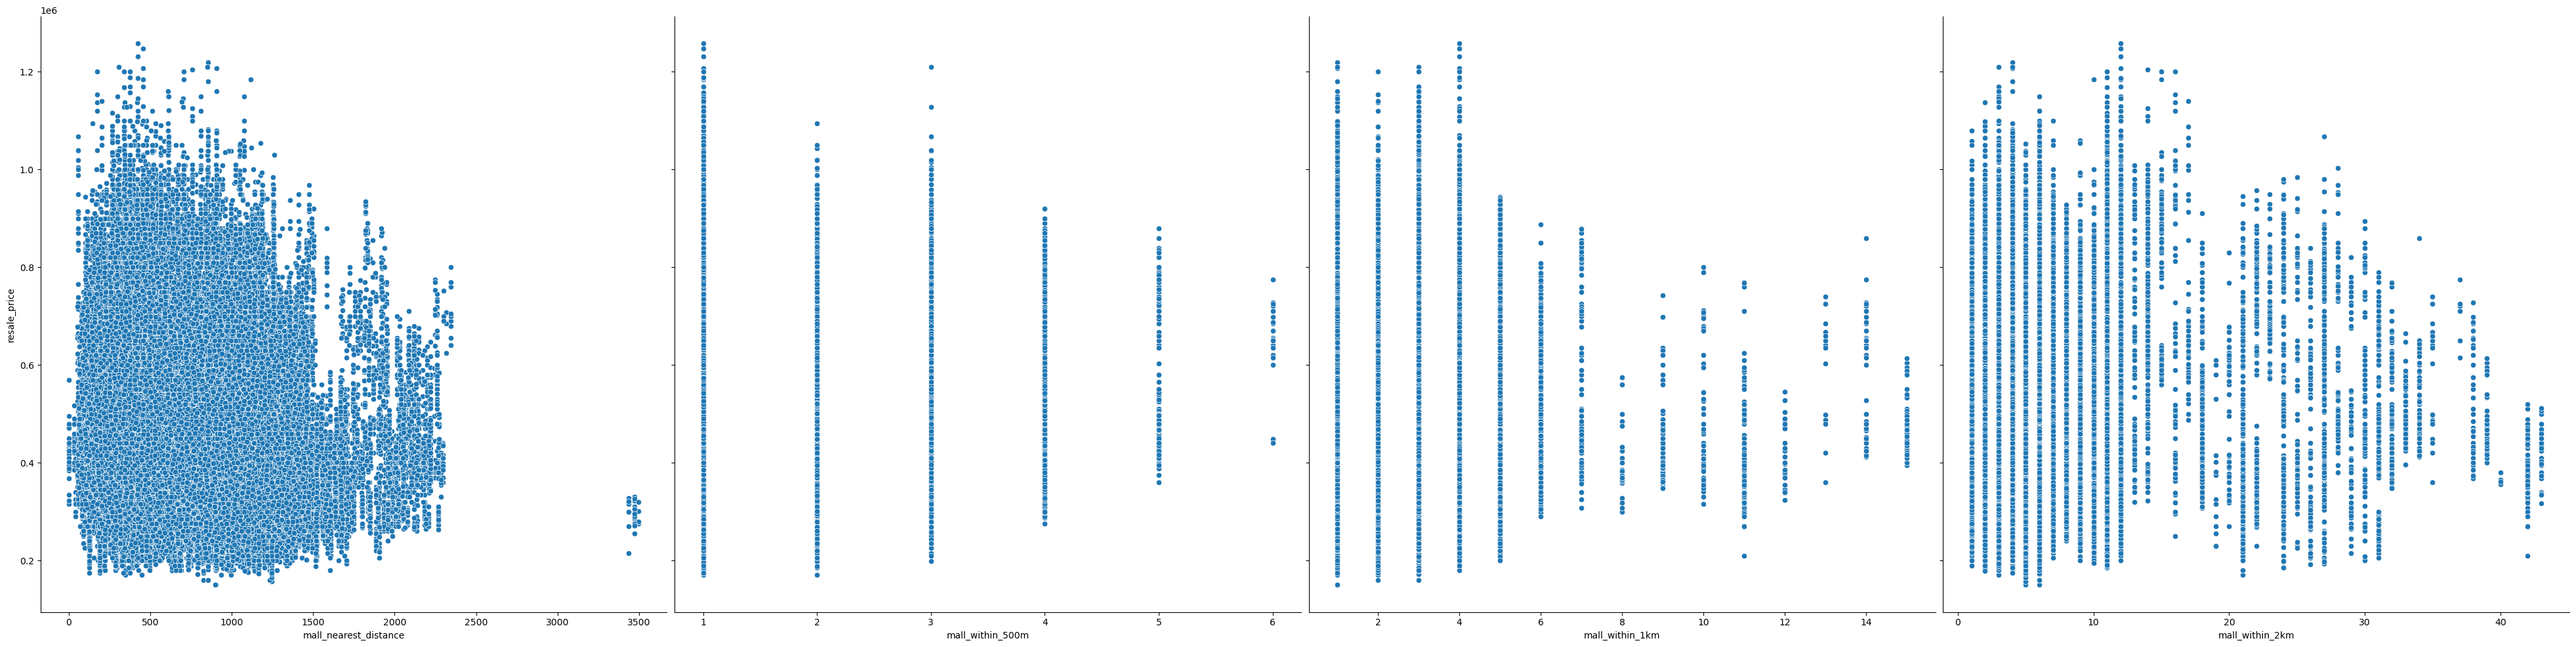

In [65]:
sns.pairplot(housing_df, x_vars=['mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km'], 
             y_vars='resale_price', height=10)

Observations:

- General neagtive correlation, and looks broadly linear as well, i.e. pattern looks consistent across the 3 categorical variables
- No signficiant break or discontinuity for numeric variable except for the Changi Village outliers
- As such, to minimise the number of predictor variables, we will use numeric variable `mall_neareest_distance`

#### `hawker` amenity

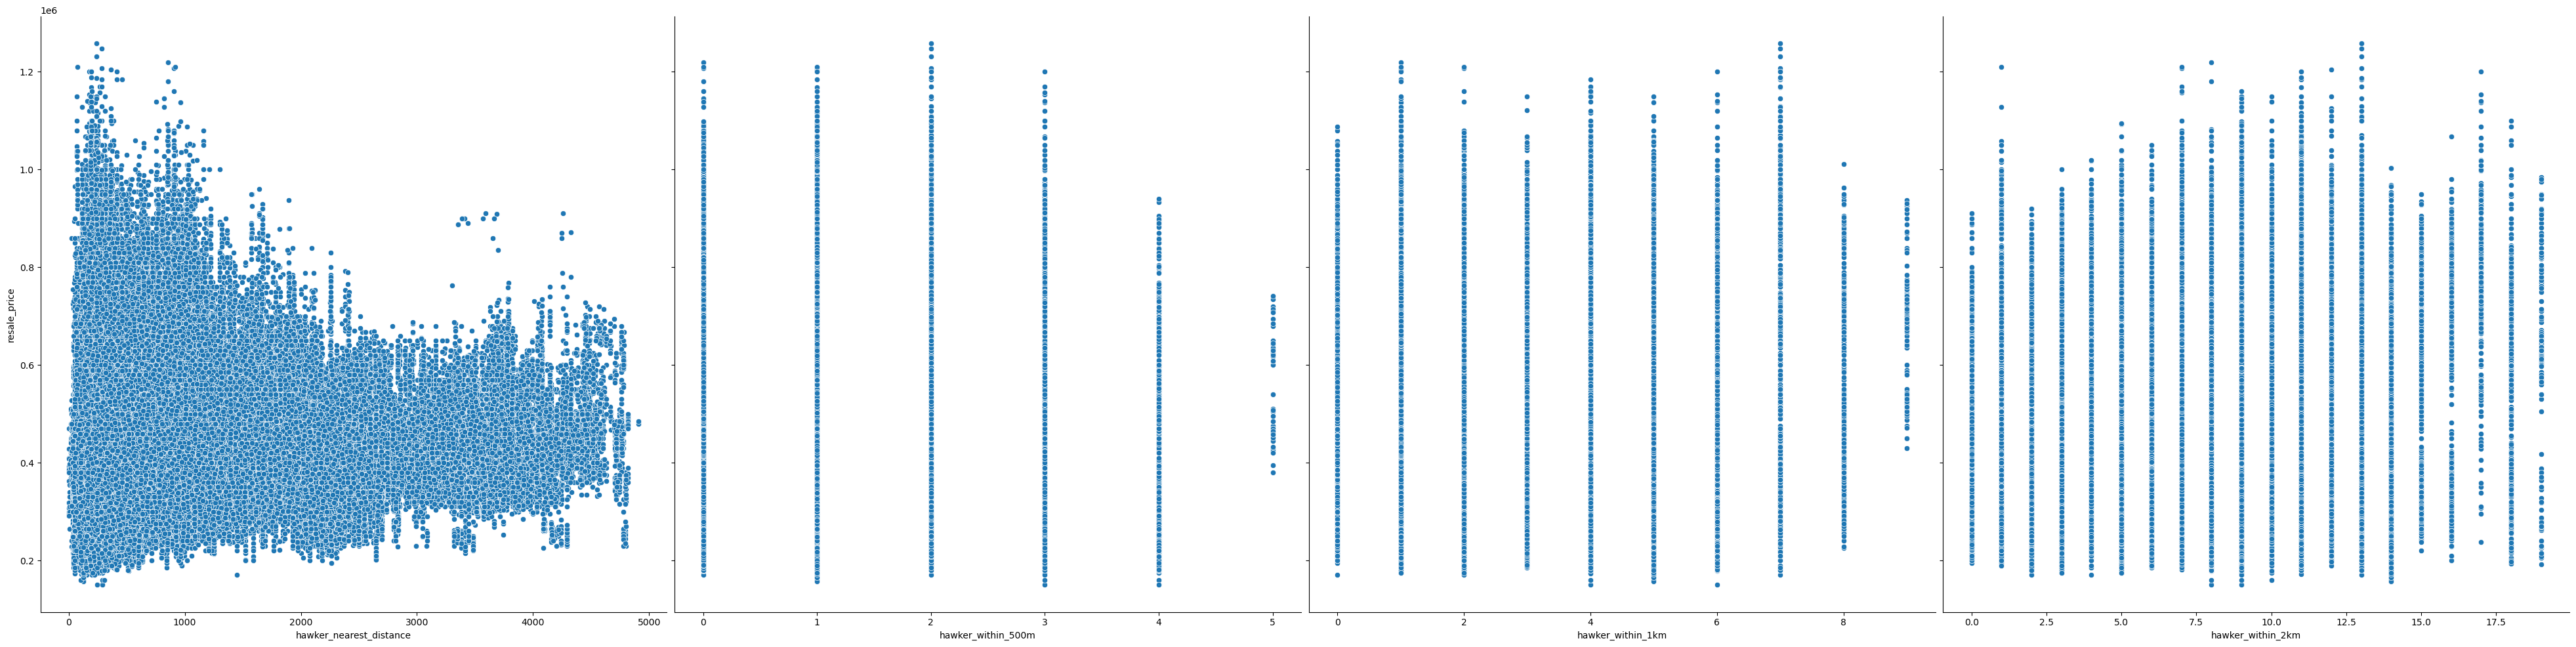

In [66]:
sns.pairplot(housing_df, x_vars=['hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km'], 
             y_vars='resale_price', height=10)

Observations:

- General neagtive correlation that is linear but flattens out after 2km
- Consider interaction term between `hawker_nearest_distance` and `hawker_within_2km` to factor in this behaviour (i.e. beyond 2km, the effect of interaction term becomes 0)


#### `mrt` amenity

In [ ]:
mrt = sns.jointplot(housing_df, x='mrt_nearest_distance', y='resale_price', kind='reg', joint_kws={'line_kws':{'color':'black'}})

In [ ]:
mrt = sns.jointplot(housing_df, x='mrt_nearest_distance', y='resale_price', marker='x', kind='reg', joint_kws={'line_kws':{'color':'black'}})

#mrt.ax_joint.set_xscale('log')
mrt.ax_joint.set_yscale('log')

Observations:

- General neagtive correlation, and looks broadly linear as well
- No signficiant break or discontinuity for numeric variable except for the Changi Village outliers
- We will use numeric variable `mrt_neareest_distance`
- Noticing that the resale price has a skewed distribution, we also consider taking the log of the resale price for a more normal distribution and better linear behaviour with predictor variables (i.e. better prediction accuracy hopefully)

In [ ]:
sns.pairplot(housing_df, x_vars=['mrt_interchange', 'bus_interchange'], 
             y_vars='resale_price', height=10)

Observations:

- Additional look at `mrt_interchange` and `bus_interchange` variables, no discernable trend with resale price
- Suspicion that the effect is interactive with distance, i.e. if the distance is close and an interchange, then there will be effect
- We will add in interaction terms for `mrt_nearest_distance`, `mrt_interchange` and `bus_interchange`

----

## Feature Engineering

We select the variables as described in the EDA above and perform the necessary transformations, i.e.

1. Dummify categorical variables
2. Impute missing values for `mall` variables
3. Add interaction term between `hawker_nearest_distance` and `hawker_within_2km`
4. Add interaction term between `mrt_nearest_distance`, `mrt_interchange` and `bus_interchange`

To avoid overfitting, we will do 2 things:

1. Gradually build up the model and see if addition of variables have any improvement to target RMSE
2. Add in regularisation as a last step to control overfitting

The models will be built with pipelines to enable modular adjustments to the models where needed. The general schema of the model is as follows:

1. **[Model D]** segment `planning_area` so that a model can be fitted for each segment
2. **[All models A, B, C and D]** take log of y for more normal distribution
3. **[All models A, B, C and D]** One-Hot Encoder to dummify categorical variables
4. **[Models B, C and D]** Impute missing values for `mall_nearest_distance`
5. **[Models C and D]** Generate polynomial features for `hawker` and `mrt` variables


In [ ]:
# create outcome variable y which will be the same for all models
y = housing_df['resale_price']

In [ ]:
# generate segments for planning_area
housing_df = generate_segments(housing_df, 'resale_price', 'planning_area', 'planning_area_grouped')

In [ ]:
housing_df['planning_area_grouped'].unique()

In [ ]:
# full model variables to be extracted from clean dataset that will be used to different extents by different models
cat_var_list = [
                'planning_area', 
                'planning_area_grouped',
                'full_flat_type'
               ]
num_var_list = [
                'hdb_age', 'mid', 'floor_area_sqft',
                'tranc_year', 'tranc_month',
                'hawker_nearest_distance', 'hawker_within_2km',
                'mrt_nearest_distance', 'bus_interchange', 'mrt_interchange',
                'mall_nearest_distance'
               ]

X = housing_df[cat_var_list + num_var_list]


### Y. Log resale price for more normal distribution

In [ ]:
# create transformer for y
lr_log = TransformedTargetRegressor(regressor=LinearRegression(),
                                    func=np.log, # define transform
                                    inverse_func=np.exp) # define inverse transform to get back y_pred

### A. Simple model without amenities

In [ ]:
# define simple model variables
cat_var_list_A = [
                'planning_area', 
                'full_flat_type'
]
num_var_list_A = [
                'hdb_age', 'mid', 'floor_area_sqft',
                'tranc_year', 'tranc_month', # we add in year and month variables to control for seasonality
]

In [ ]:
# dummy identity scaler to passthrough variables selected without further adjustments
identity_transformer = FunctionTransformer(lambda x: x, feature_names_out='one-to-one')

In [ ]:
# create one-hot encoder object
cat_transformer = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

In [ ]:
# simple model
# PIPE: entire preprocessor pipeline, generates only the transformed X needed for simple model

preprocessor_A = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var_list_A),
        ('dummy', identity_transformer, num_var_list_A)
    ],
    remainder='drop', verbose_feature_names_out=False
)

### B. Model with amenities

In [ ]:
# create imputer for mall_nearest_distance
imp_transformer = KNNImputer()

In [ ]:
# full model without interaction terms
# PIPE: entire preprocessor pipeline, generates only the transformed X needed for simple model
cat_var_list_B = [
                'planning_area', 
                'full_flat_type'
]

num_var_list_B = num_var_list.copy()
num_var_list_B.remove('mall_nearest_distance')

preprocessor_B = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var_list_B),
        ('imp', imp_transformer, ['mall_nearest_distance']),
        ('dummy', identity_transformer, num_var_list_B) # identity transform all variables except last one which is the mall_nearest_distance
    ],
    remainder='drop', verbose_feature_names_out=False
)

### C. Model with amenities and interaction

In [ ]:
# create polynomial features transfomrer for interactive terms
poly_hawk_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_mrt_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [ ]:
# full model with interaction terms
# PIPE: entire preprocessor pipeline, generates only the transformed X needed for simple model
cat_var_list_C = [
                'planning_area', 
                'full_flat_type'
]

num_var_list_C = [variable for variable in num_var_list if variable not in ['mall_nearest_distance',
                                                                           'hawker_nearest_distance',
                                                                           'hawker_within_2km',
                                                                           'mrt_nearest_distance',
                                                                           'mrt_interchange',
                                                                           'bus_interchange']
                 ]

preprocessor_C = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var_list_C),
        ('imp', imp_transformer, ['mall_nearest_distance']),
        ('poly_hawk', poly_hawk_transformer, ['hawker_nearest_distance', 'hawker_within_2km']),
        ('poly_mrt', poly_mrt_transformer, ['mrt_nearest_distance', 'mrt_interchange', 'bus_interchange']),
        ('dummy', identity_transformer, num_var_list_C) # identity transform all variables except for the last 6 that have passed through interaction transformer
    ],
    remainder='drop', verbose_feature_names_out=False
)

### D. Subsegment models with amenities and interaction

In [ ]:
# model D only categorises full_flat_type, since planning_area will be subsegmented
cat_var_list_D = [
                'full_flat_type'
                 ]


In [ ]:
# set up full model with interaction terms first
# PIPE: entire preprocessor pipeline, generates only the transformed X needed for simple model

num_var_list_D = [variable for variable in num_var_list if variable not in ['mall_nearest_distance',
                                                                           'hawker_nearest_distance',
                                                                           'hawker_within_2km',
                                                                           'mrt_nearest_distance',
                                                                           'mrt_interchange',
                                                                           'bus_interchange']
                 ]

preprocessor_D = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var_list_D),
        ('imp', imp_transformer, ['mall_nearest_distance']),
        ('poly_hawk', poly_hawk_transformer, ['hawker_nearest_distance', 'hawker_within_2km']),
        ('poly_mrt', poly_mrt_transformer, ['mrt_nearest_distance', 'mrt_interchange', 'bus_interchange']),
        ('dummy', identity_transformer, num_var_list_D) # identity transform all variables except for the last 6 that have passed through interaction transformer
    ],
    remainder='drop', verbose_feature_names_out=False
)

In [ ]:
# get the mapping from planning_area to planning_area_grouped so that production model can use the mapping
segment_mapping = X.groupby('planning_area')['planning_area_grouped'].apply(lambda x: set(x).pop()).to_dict()

----

## Data and Preprocessor Export

We then export the preprocessors in preparation for model evaluation (including regularisation in the next step)

In [ ]:
# export data
X.to_csv('../datasets/X.csv')
y.to_csv('../datasets/y.csv')

In [ ]:
# define folder path for saved models
folder_path = '../models/'

In [ ]:
# saving preprocessors
dill.dump(preprocessor_A, open(folder_path + 'preprocessor_A.sav', 'wb'))
dill.dump(preprocessor_B, open(folder_path + 'preprocessor_B.sav', 'wb'))
dill.dump(preprocessor_C, open(folder_path + 'preprocessor_C.sav', 'wb'))
dill.dump(preprocessor_C, open(folder_path + 'preprocessor_D.sav', 'wb'))

In [ ]:
# saving regression transformer
dill.dump(lr_log, open(folder_path + 'lr_log.sav', 'wb'))

In [ ]:
# saving the mapping of segments for planning_area
dill.dump(segment_mapping, open(folder_path + 'planning_area_mapping.sav', 'wb'))